In [93]:
import scipy
import numpy as np
import scipy.constants as constants
import math
import matplotlib.pyplot as plt

m = 1e-13
temp = 273
K = 1e-4
r = 3e-6
eta = 1e-3
rho_f = 789

times = np.logspace(-8, -2, 60)
zeros = np.zeros(len(times))


1.768388256576615e-06


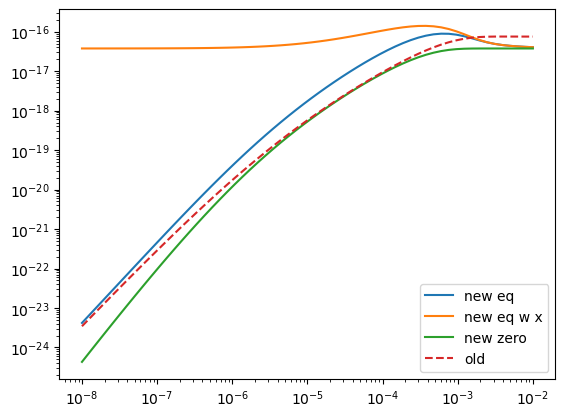

In [94]:
def hydro_msd(t):
    trap_const = K
    use_mass = m
    m_f = 2 / 3 * np.pi * r ** 3 * 1000
    t_k = (6 * np.pi * r * eta) / K
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * np.pi * r * eta)
    print(t_p)
    # find roots
    # a * z^4 + b * z^3 + c * z^2 + d * z + e = 0
    a_ = t_p
    b = -1 * np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    # Coefficients array for the polynomial equation
    coefficients = [a_, b, c, d, e]

    # Find the roots
    roots = np.roots(coefficients)

    # I need to learn how to vectorize my code better
    term_1 = scipy.special.erfcx(roots[0] * np.sqrt(t)) / (
                roots[0] * (roots[0] - roots[1]) * (roots[0] - roots[2]) * (roots[0] - roots[3]))
    term_2 = scipy.special.erfcx(roots[1] * np.sqrt(t)) / (
                roots[1] * (roots[1] - roots[0]) * (roots[1] - roots[2]) * (roots[1] - roots[3]))
    term_3 = scipy.special.erfcx(roots[2] * np.sqrt(t)) / (
                roots[2] * (roots[2] - roots[1]) * (roots[2] - roots[0]) * (roots[2] - roots[3]))
    term_4 = scipy.special.erfcx(roots[3] * np.sqrt(t)) / (
                roots[3] * (roots[3] - roots[1]) * (roots[3] - roots[2]) * (roots[3] - roots[0]))

    D = constants.k * temp / (6 * np.pi * eta * r)
    # Returns theoretical MSD
    return np.real(2 * constants.k * temp / trap_const + 2 * constants.k * temp / (use_mass) * (
                term_1 + term_2 + term_3 + term_4))


# NEW AND CORRECTED CODE

def a_inverse_form(t, roots):
    return (1/m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

def b_inverse_form(t, roots):
    return (1/m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

def c_inverse_form(t, roots):
    a = roots[0]
    b = roots[1]
    c = roots[2]
    d = roots[3]

    m_over_k = 1/(a*b*c*d)

    ret = (1/m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (z*(np.prod([z - z_j for z_j in roots if z != z_j]))) for z in roots)

    return ret + m_over_k/m

def s_half_b_inverse_form(t, roots):
    return (-1/m) * sum(
        (z**2 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

def s_minus_half_b_inverse_form(t, roots):
     return (-1/m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

def ensemble_r_term(t1, t2, m, K, roots):
    return (constants.k*temp)*(c_inverse_form(t1, roots) + c_inverse_form(t2, roots) - c_inverse_form(np.abs(t2-t1), roots) - m*b_inverse_form(t1, roots)*b_inverse_form(t2, roots) - K*c_inverse_form(t1, roots)*c_inverse_form(t2, roots))

def e_and_f(t, mass, radius, rho, eta, x0, v0, roots):
    gamma = 6*np.pi*radius*eta
    z = 6*radius**2*np.pi*np.sqrt(rho*eta)
    return mass*x0*a_inverse_form(t, roots) + mass*v0*b_inverse_form(t, roots) + gamma*x0*b_inverse_form(t, roots) + z*x0*s_half_b_inverse_form(t, roots) + z*v0*s_minus_half_b_inverse_form(t, roots)

# Returns <x(t1)x(t2)> - note that MSD when x(0) = Zero is defined by <x(t)^2>
def x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    roots = compute_roots(m, K, radius, eta, rho_f)
    return e_and_f(t1, m, radius, rho_f, eta, x0, v0, roots)*e_and_f(t2, m, radius, rho_f, eta, x0, v0, roots) + ensemble_r_term(t1,t2, m, K, roots)


def compute_roots(m, K, r, eta, rho_f):
    t_k = (6 * math.pi * r * eta) / K
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * math.pi * r * eta)

    a = t_p
    b = -np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    coeffs = [a, b, c, d, e]
    return np.roots(coeffs)

avg_squared_xt = x_t1_x_t2(times, times, m, K, r, eta, rho_f, 0, np.sqrt(constants.k*temp/m))
avg_squared_xt1 = x_t1_x_t2(times, times, m, K, r, eta, rho_f, np.sqrt(constants.k*temp/K), np.sqrt(constants.k*temp/m))
avg_squared_xt2 = x_t1_x_t2(times, times, m, K, r, eta, rho_f, 0, 0)

roots_ = compute_roots(m, K, r, eta, rho_f)
old_code = hydro_msd(times)

# plt.plot(times, e_f, label="ef")
plt.plot(times, avg_squared_xt, label = "new eq")
plt.plot(times, avg_squared_xt1, label = "new eq w x")
plt.plot(times, avg_squared_xt2, label = "new zero")
plt.plot(times, old_code, linestyle="dashed", label = "old")

plt.legend()
plt.xscale('log')
plt.yscale('log')


C:\Users\mcthu\AppData\Local\Temp\ipykernel_21444\1138945097.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  results[i, :] = x_t1_x_t2(times, times, m, K, r, eta, rho_f, 0, v0)


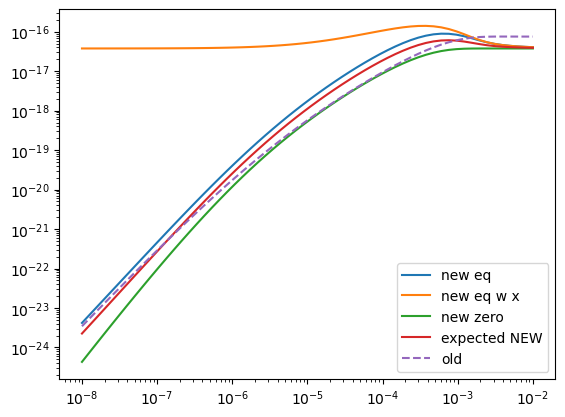

In [95]:
from scipy.stats import norm
mu = 0      # Mean of the normal distribution
sigma = np.sqrt(constants.k*temp/m)   # Standard deviation
num_samples = 1000  # Number of initial condition samples

# Step 3: Generate samples of initial conditions from the distribution
np.random.seed(42)  # For reproducibility
initial_conditions = np.random.normal(mu, sigma, num_samples)

# Step 4: Compute weights for each initial condition
weights = norm.pdf(initial_conditions, mu, sigma)
weights = weights / np.sum(weights)  # Normalize weights to sum to 1

# Step 5: Apply the function to each initial condition over all times
# Initialize output array: rows = initial conditions, columns = time points
results = np.zeros((num_samples, len(times)))

for i, v0 in enumerate(initial_conditions):
    results[i, :] = x_t1_x_t2(times, times, m, K, r, eta, rho_f, 0, v0)

# Step 6: Weight the results by the distribution weights
# Weighting is applied across initial conditions (rows)
weighted_results = results * weights[:, np.newaxis]  # Broadcasting weights to each time point

# Step 7: Aggregate or analyze the results
# Example: Compute the expected value at each time point
expected_values_over_time = np.sum(weighted_results, axis=0)

plt.plot(times, avg_squared_xt, label = "new eq")
plt.plot(times, avg_squared_xt1, label = "new eq w x")
plt.plot(times, avg_squared_xt2, label = "new zero")
plt.plot(times, expected_values_over_time, label = "expected NEW")
plt.plot(times, old_code, linestyle="dashed", label = "old")

plt.legend()
plt.xscale('log')
plt.yscale('log')
